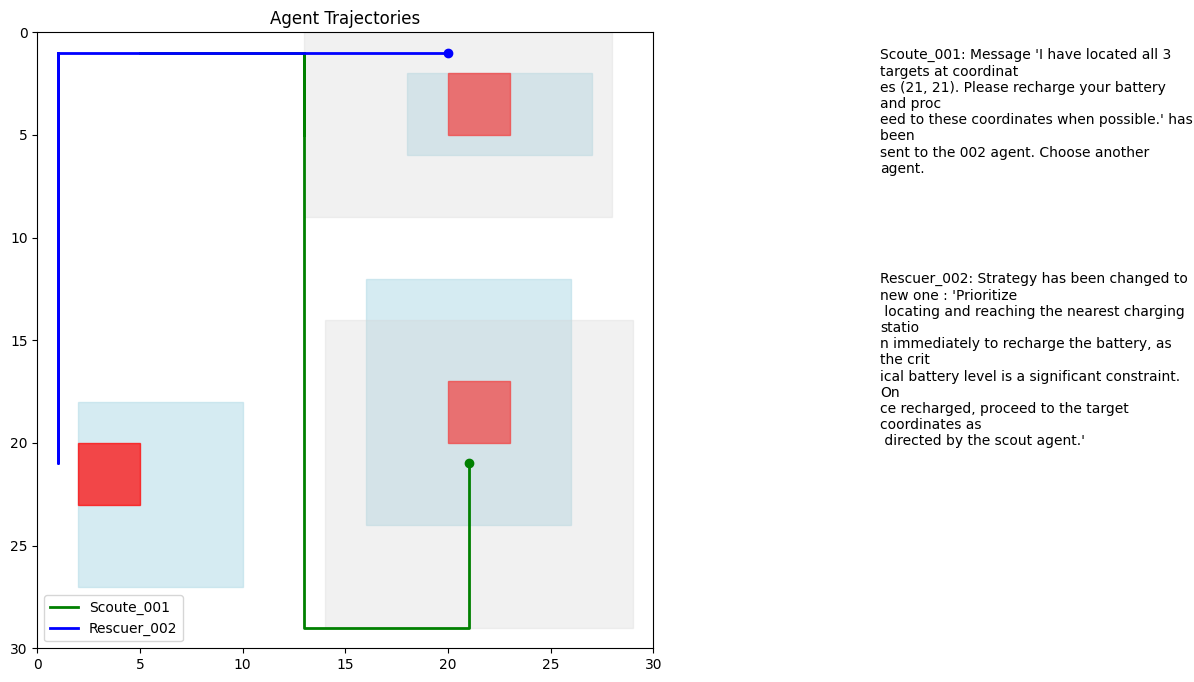

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from collections import defaultdict
import json

# Load data
exp_path = "v2/experiments/gpt-4o/✰v8"
metadata_fname = "metadata"
# agents = ["Scoute_001", "Scoute_003", "Rescuer_002"]
# colors = ['green', 'lime', 'blue']
agents = ["Scoute_001", "Rescuer_002"]
colors = ['green', 'blue']


agent_data = defaultdict()
for agent in agents:
    with open(f"{exp_path}/{agent}.json", 'r') as file:
        agent_data[agent] = json.load(file)

with open(f"{exp_path}/{metadata_fname}.json", 'r') as file:
    metadata = json.load(file)

# Extract metadata
area_size = metadata['area_size']
targets = np.array(metadata['targets'])
zones_of_interest = metadata['zones_of_interest']

# Observation area size
observation_area_size = (15, 15)

# Target area size
target_size = (3, 3)

# Determine number of iterations from agent data
iterations = max(len(agent_data[agent]) for agent in agents)

# Prepare the figure
fig, ax = plt.subplots(figsize=(14, 8))  # Increased width further for better allocation
ax.set_xlim(0, area_size[1])  # X-axis limits
ax.set_ylim(area_size[0], 0)  # Y-axis limits flipped for image-like coordinates
ax.set_aspect('equal')

# Create a secondary axis for agent messages
fig.subplots_adjust(left=0.05, right=0.75)  # Adjust to center environment and allocate message space
text_ax = fig.add_axes([0.78, 0.1, 0.2, 0.8])  # [left, bottom, width, height]
text_ax.axis('off')

# Plot static elements (targets and zones of interest)
# Light blue zones of interest
for zone in zones_of_interest:
    (y1, x1), (y2, x2) = zone
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, color='lightblue', alpha=0.5)
    ax.add_patch(rect)

# Red target areas
for target in targets:
    rect = plt.Rectangle((target[1] - target_size[1] // 2, target[0] - target_size[0] // 2), 
                         target_size[1], target_size[0], color='red', alpha=0.7)
    ax.add_patch(rect)

# Initialize dynamic elements (agent trajectories and observation areas)
lines = {}
points = {}
observation_areas = {}
for i, agent in enumerate(agents):
    lines[agent], = ax.plot([], [], '-', lw=2, color=colors[i], label=agent)
    points[agent], = ax.plot([], [], 'o', color=colors[i])
    observation_areas[agent] = plt.Rectangle((0, 0), 0, 0, color='lightgray', alpha=0.3)
    ax.add_patch(observation_areas[agent])

# Initialize text elements for messages
messages = {agent: text_ax.text(0.01, 0.95 - i * 0.35, f"{agent}: ", transform=text_ax.transAxes, fontsize=10, wrap=True, verticalalignment='top', ha='left') for i, agent in enumerate(agents)}

# Title and legend
ax.set_title('Agent Trajectories')
ax.legend()

# Update function for animation
def update(frame):
    for agent in agents:
        if frame < len(agent_data[agent]):  # Skip update if frame exceeds agent's data length
            trajectory = np.array([agent_data[agent][str(step)]["current_position"] for step in range(frame + 1)])
            if len(trajectory.shape) == 2 and trajectory.shape[1] == 2:  # Ensure correct shape
                lines[agent].set_data(trajectory[:, 1], trajectory[:, 0])
                points[agent].set_data([trajectory[-1, 1]], [trajectory[-1, 0]])  # Wrap in lists

                # Update observation area
                current_position = trajectory[-1]
                observation_areas[agent].set_xy((current_position[1] - observation_area_size[1] // 2, 
                                                 current_position[0] - observation_area_size[0] // 2))
                observation_areas[agent].set_width(observation_area_size[1])
                observation_areas[agent].set_height(observation_area_size[0])

                # Update message
                message = agent_data[agent][str(frame)]["messages"][-1] if "messages" in agent_data[agent][str(frame)] else "No message"
                wrapped_message = "\n".join(message[i:i+50] for i in range(0, len(message), 50))  # Wrap message text
                messages[agent].set_text(f"{agent}: {wrapped_message}")
            else:
                print(f"Invalid trajectory shape for {agent}: {trajectory}")

    return list(lines.values()) + list(points.values()) + list(observation_areas.values()) + list(messages.values())

# Create animation
anim = FuncAnimation(fig, update, frames=iterations, interval=500, blit=True)

# Save animation as video
video_path = f"{exp_path}/rollout.mp4"
from matplotlib.animation import FFMpegWriter
anim.save(video_path, writer=FFMpegWriter(fps=2, metadata={"title": "Agent Trajectories with Messages"}))

# Display animation live
plt.show()
